# **Klasfikasi Suara**

Pengenalan suara adalah teknologi yang memungkinkan komputer atau mesin 
untuk mengenali, memahami, dan memproses ucapan manusia sehingga dapat 
diterjemahkan menjadi perintah atau teks. Teknologi ini semakin banyak 
digunakan dalam kehidupan sehari-hari, mulai dari asisten virtual hingga 
sistem kontrol perangkat pintar.

Dalam analisis ini, saya mencoba membangun model sederhana yang mampu 
membedakan dua kata perintah dasar: **"buka"** dan **"tutup"** dan model identifikasi suara orang(speaker): **SAHL** dan **NAUFAL**. Dataset 
yang digunakan berasal dari rekaman suara sendiri.


## **1. Data Understanding & Preprocessing Awal**

### **1.1 Install Dependency yang diperlukan**

In [ ]:
pip install librosa soundfile numpy matplotlib seaborn scikit-learn pydub ffmpeg-python joblib soundfile tsfel

In [3]:
import os
from pydub import AudioSegment
import pandas as pd
import librosa
import tsfel
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib




### **1.2 Konversi data suara dari .m4a ke .wav**

In [ ]:
input_folder = "data_suara"             
output_folder = "data_suara_wav"        
os.makedirs(output_folder, exist_ok=True)

count = 0
for root, dirs, files in os.walk(input_folder):
    for file in files:
        if file.lower().endswith(".m4a"):
            src = os.path.join(root, file)
            rel = os.path.relpath(root, input_folder)
            dst_dir = os.path.join(output_folder, rel)
            os.makedirs(dst_dir, exist_ok=True)
            dst = os.path.join(dst_dir, file.replace(".m4a", ".wav"))
            if not os.path.exists(dst):
                try:
                    audio = AudioSegment.from_file(src, format="m4a")
                    audio.export(dst, format="wav")
                except Exception as e:
                    print(f"Gagal mengonversi {src}: {e}")
            count += 1

print("Total file .m4a diperiksa:", count)

Total file .m4a diperiksa: 400


### **1.3 Muat Dataset .wav dan Pahami Datanya**

In [2]:
import os
import pandas as pd

DATA_DIR = "data_suara_wav"

audio_files = []
labels = []

for label in os.listdir(DATA_DIR):
    subfolder = os.path.join(DATA_DIR, label)
    if not os.path.isdir(subfolder): continue
    for filename in os.listdir(subfolder):
        if filename.lower().endswith((".wav")):
            file_path = os.path.join(subfolder, filename)
            audio_files.append(file_path)
            labels.append(label)

df = pd.DataFrame({"file": audio_files, "label": labels})

print("Jumlah data per label:")
print(df['label'].value_counts())
df.head()

Jumlah data per label:
label
buka_naufal     100
buka_sahl       100
tutup_naufal    100
tutup_sahl      100
Name: count, dtype: int64


,file,label
0,data_suara_wav\buka_naufal\Buka-1.wav,buka_naufal
1,data_suara_wav\buka_naufal\Buka-10.wav,buka_naufal
2,data_suara_wav\buka_naufal\Buka-100.wav,buka_naufal
3,data_suara_wav\buka_naufal\Buka-11.wav,buka_naufal
4,data_suara_wav\buka_naufal\Buka-12.wav,buka_naufal


### **1.4 Deskripsi dasar suara**

In [4]:
import librosa

durations = []
sample_rates = []

for f in df['file']:
    y, sr = librosa.load(f, sr=16000, mono=True)
    durations.append(len(y)/sr)
    sample_rates.append(sr)

df["duration_sec"] = durations
df["sample_rate"] = sample_rates

df.describe()

,duration_sec,sample_rate
count,400.000000,400.0
mean,1.571892,16000.0
std,0.523434,0.0
min,0.557312,16000.0
25%,1.184250,16000.0
50%,1.579000,16000.0
75%,1.920000,16000.0
max,3.754688,16000.0


## **2. Preprocessing & Ekstraksi Fitur**

### **2.1 Normalisasi, Trimming, dan Padding Suara**

In [39]:
TARGET_SR = 16000
TARGET_DURATION = 3.0
TARGET_SAMPLES = int(TARGET_SR * TARGET_DURATION)

input_folder = "data_suara_wav"
output_folder = "data_suara_preprocessed"


def pre_emphasis(y, coef=0.97):
    return lfilter([1, -coef], [1], y)

def highpass_filter(y, sr, cutoff=80):
    b, a = butter(2, cutoff / (sr / 2), btype='high')
    return lfilter(b, a, y)

def rms_normalize(y, target_rms=0.1):
    rms = np.sqrt(np.mean(y**2))
    if rms > 0:
        y = y * (target_rms / rms)
    return y

def soft_trim(y, threshold_db=-35, frame_length=2048, hop_length=512):
    energy = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    energy_db = librosa.amplitude_to_db(energy, ref=np.max)

    mask = energy_db > threshold_db
    if not np.any(mask):
        return y

    first = np.argmax(mask)
    last = len(mask) - np.argmax(mask[::-1])

    start = max(0, first * hop_length - 128)
    end = min(len(y), last * hop_length + 128)

    return y[start:end]


def preprocess_audio(path):
    # Load
    y, sr = librosa.load(path, sr=TARGET_SR, mono=True)

    # Pre-emphasis
    y = pre_emphasis(y)

    # High-pass
    y = highpass_filter(y, TARGET_SR)

    # Soft trim
    y = soft_trim(y)

    # RMS normalize
    y = rms_normalize(y)

    # Pad / crop 
    if len(y) < TARGET_SAMPLES:
        pad = TARGET_SAMPLES - len(y)
        left = pad // 2
        right = pad - left
        y = np.pad(y, (left, right), mode='constant')
    else:
        y = y[:TARGET_SAMPLES]

    return y, TARGET_SR



os.makedirs(output_folder, exist_ok=True)
count = 0

for root, dirs, files in os.walk(input_folder):
    for file in files:
        if file.lower().endswith(".wav"):

            src = os.path.join(root, file)

    
            rel = os.path.relpath(root, input_folder)
            dst_dir = os.path.join(output_folder, rel)
            os.makedirs(dst_dir, exist_ok=True)

            # preprocess
            y, sr = preprocess_audio(src)

            # save
            dst = os.path.join(dst_dir, file)
            sf.write(dst, y, sr)

            count += 1

print("Total file diproses:", count)


Total file diproses: 400


### **2.2 Ekstraksi Fitur**

In [74]:


INPUT_DIR = "data_suara_preprocessed"
TARGET_SR = 16000

cfg = tsfel.get_features_by_domain()
cfg = {k: cfg[k] for k in ['temporal', 'statistical', 'spectral']}  # filter 3 domain

def load_audio(path):
    y, _ = librosa.load(path, sr=TARGET_SR, mono=True)
    return y

rows = []

for root, _, files in os.walk(INPUT_DIR):
    for file in files:
        if file.lower().endswith(".wav"):
            y = load_audio(os.path.join(root, file))
            feats_df = tsfel.time_series_features_extractor(cfg, y, fs=TARGET_SR)
            feats = feats_df.iloc[0].to_dict()  
            feats["filename"] = file
            feats["kelas"] = "buka" if "buka" in root.lower() else "tutup"
            feats["speaker"] = "naufal" if "naufal" in root.lower() else "sahl"
            rows.append(feats)

df = pd.DataFrame(rows)
print("Jumlah fitur:", df.shape[1] - 3)  # tanpa filename, kelas, speaker
print("Shape:", df.shape)
df.to_csv("audio_fitur.csv", index=False)


Jumlah fitur: 156
Shape: (400, 159)


In [64]:
print(df)

     0_Absolute energy  0_Area under the curve  0_Autocorrelation  \
0            85.342079                0.017317                1.0   
1           312.143397                0.078644                2.0   
2           324.270121                0.124442                2.0   
3           273.070085                0.077042                1.0   
4           310.620514                0.113615                3.0   
..                 ...                     ...                ...   
395         133.630195                0.057440                6.0   
396         152.199936                0.066816                6.0   
397         123.389774                0.048191                6.0   
398         107.431845                0.038958                5.0   
399         185.640205                0.089154                6.0   

     0_Average power  0_Centroid  0_ECDF Percentile Count_0  \
0          28.447952    1.197139                        0.0   
1         104.049967    1.630449             

### **2.3 Seleksi Fitur menggunakan Information Gain**

[kelas] Jumlah fitur terpilih: 91
[kelas] Fitur terpilih: ['0_Spectrogram mean coefficient_1290.32Hz', '0_Spectrogram mean coefficient_1548.39Hz', '0_Signal distance', '0_LPCC_5', '0_LPCC_7', '0_Zero crossing rate', '0_Wavelet entropy', '0_Spectrogram mean coefficient_2064.52Hz', '0_Spectrogram mean coefficient_2322.58Hz', '0_Autocorrelation', '0_Max', '0_Spectrogram mean coefficient_5419.35Hz', '0_Spectrogram mean coefficient_5161.29Hz', '0_Spectrogram mean coefficient_5677.42Hz', '0_Spectral entropy', '0_Power bandwidth', '0_Spectrogram mean coefficient_774.19Hz', '0_Wavelet standard deviation_2000.0Hz', '0_Wavelet energy_2000.0Hz', '0_Wavelet variance_2000.0Hz', '0_Spectrogram mean coefficient_3870.97Hz', '0_Spectrogram mean coefficient_4903.23Hz', '0_Wavelet variance_500.0Hz', '0_Wavelet standard deviation_1000.0Hz', '0_Wavelet energy_1000.0Hz', '0_Wavelet energy_500.0Hz', '0_Wavelet standard deviation_500.0Hz', '0_Wavelet variance_1000.0Hz', '0_Spectrogram mean coefficient_3612.9H

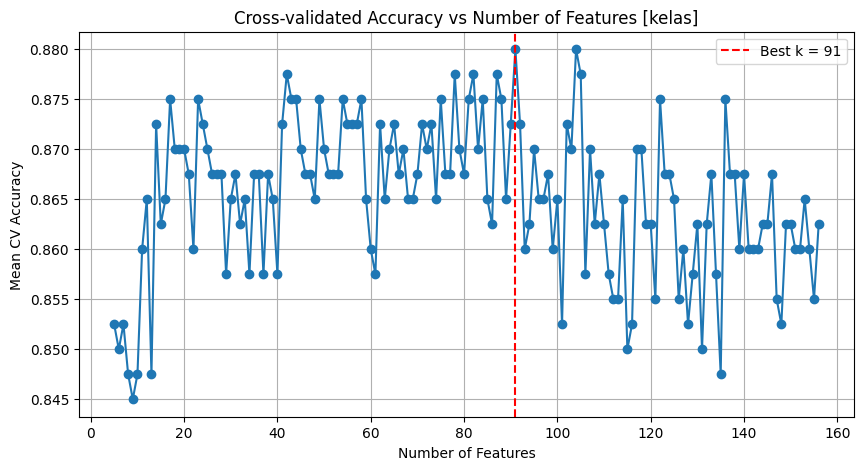

[speaker] Jumlah fitur terpilih: 60
[speaker] Fitur terpilih: ['0_Spectrogram mean coefficient_5677.42Hz', '0_Signal distance', '0_Spectrogram mean coefficient_5935.48Hz', '0_Zero crossing rate', '0_Spectrogram mean coefficient_6193.55Hz', '0_Spectrogram mean coefficient_5419.35Hz', '0_Spectrogram mean coefficient_6451.61Hz', '0_Spectrogram mean coefficient_4387.1Hz', '0_Spectral kurtosis', '0_Spectral skewness', '0_LPCC_1', '0_LPCC_11', '0_Sum absolute diff', '0_Mean absolute diff', '0_Power bandwidth', '0_Spectrogram mean coefficient_5161.29Hz', '0_Spectrogram mean coefficient_4903.23Hz', '0_Spectrogram mean coefficient_8000.0Hz', '0_Spectrogram mean coefficient_6709.68Hz', '0_Spectral centroid', '0_Spectral slope', '0_Positive turning points', '0_Spectrogram mean coefficient_4645.16Hz', '0_Negative turning points', '0_Spectrogram mean coefficient_7741.94Hz', '0_Wavelet entropy', '0_Spectrogram mean coefficient_7225.81Hz', '0_Spectrogram mean coefficient_4129.03Hz', '0_Spectrogram me

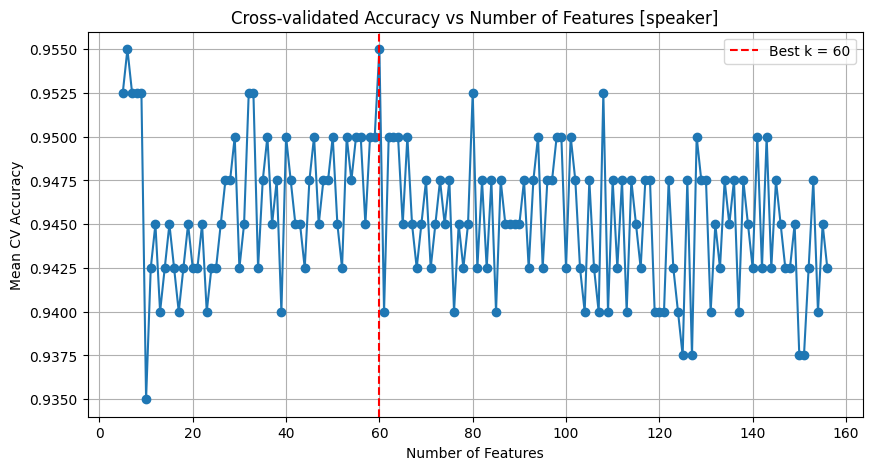

In [4]:


df = pd.read_csv("audio_fitur.csv")
targets = ["kelas", "speaker"]
feature_cols = [c for c in df.columns if c not in targets + ["filename"]]

for target in targets:
    X = df[feature_cols].values
    y = df[target].values

    mi = mutual_info_classif(X, y, discrete_features=False)
    mi = np.nan_to_num(mi)
    mi_order = np.argsort(mi)[::-1]
    sorted_features = [feature_cols[i] for i in mi_order]

    score_history = []
    for k in range(5, len(sorted_features)+1):
        subset = sorted_features[:k]
        clf = RandomForestClassifier(n_estimators=200, random_state=42)
        scores = cross_val_score(clf, df[subset], y, cv=StratifiedKFold(5))
        mean_score = scores.mean()
        score_history.append((k, mean_score))

    ks = [x[0] for x in score_history]
    scores = [x[1] for x in score_history]

    best_k, best_score = max(score_history, key=lambda x: x[1])
    best_features = sorted_features[:best_k]

    print(f"[{target}] Jumlah fitur terpilih: {len(best_features)}")
    print(f"[{target}] Fitur terpilih: {best_features}\n")

    df_subset = df[best_features + [target]]
    df_subset.to_csv(f"audio_fitur_terpilih_{target}.csv", index=False)

    plt.figure(figsize=(10, 5))
    plt.plot(ks, scores, marker='o')
    plt.axvline(best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
    plt.title(f'Cross-validated Accuracy vs Number of Features [{target}]')
    plt.xlabel('Number of Features')
    plt.ylabel('Mean CV Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


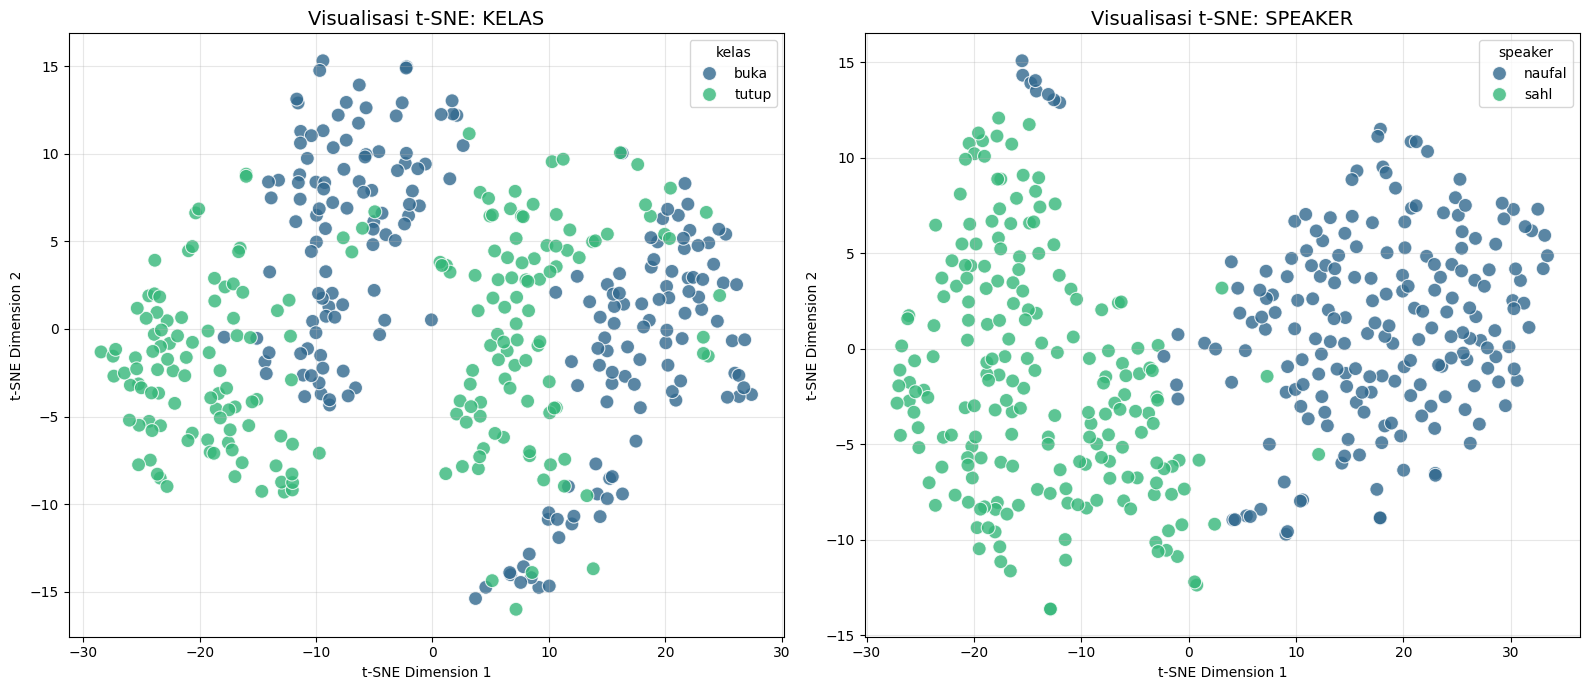

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler    

# Daftar target yang mau divisualisasikan
targets = ["kelas", "speaker"]

plt.figure(figsize=(16, 7))

for i, target in enumerate(targets):
    # 1. Load Data
    try:
        filename = f"audio_fitur_terpilih_{target}.csv"
        df_selected = pd.read_csv(filename)
    except FileNotFoundError:
        print(f"File {filename} tidak ditemukan. Pastikan sudah menjalankan tahap seleksi fitur.")
        continue

    # Pisahkan fitur dan label
    features = [c for c in df_selected.columns if c != target]
    X = df_selected[features].values
    y = df_selected[target].values

    # 2. Scaling (PENTING untuk t-SNE)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. Jalankan t-SNE
    # HAPUS 'n_iter=1000' dari sini
    tsne = TSNE(n_components=2, verbose=0, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    # 4. Plotting
    plt.subplot(1, 2, i+1)
    sns.scatterplot(
        x=X_tsne[:, 0], 
        y=X_tsne[:, 1],
        hue=y,
        palette="viridis",
        s=100,
        alpha=0.8
    )
    
    plt.title(f'Visualisasi t-SNE: {target.upper()}', fontsize=14)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title=target)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **3. Modelling**

### **3.1 Training Model**

In [115]:


targets = ["kelas", "speaker"]

for target in targets:
    # Load fitur terpilih
    df_selected = pd.read_csv(f"audio_fitur_terpilih_{target}.csv")
    features = [c for c in df_selected.columns if c != target]

    X = df_selected[features].values
    y = df_selected[target].values

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Pipeline scaling + Logistic Regression
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=5000, random_state=42))
    ])

    # Fit pipeline
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Evaluasi
    print(f"=== Evaluasi Logistic Regression [{target}] ===")
    print(f"Akurasi Test: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv)
    print(f"CV Mean Accuracy: {scores.mean():.4f}\n")

    # Simpan pipeline, scaler, dan fitur
    joblib.dump(clf, f"logreg_{target}_pipeline.joblib")
    joblib.dump(clf.named_steps['scaler'], f"scaler_{target}.joblib")
    pd.DataFrame({"feature": features}).to_csv(f"features_{target}.csv", index=False)
    print(f"[SIMPAN] {target}: pipeline, scaler, dan fitur berhasil disimpan.\n")


=== Evaluasi Logistic Regression [kelas] ===
Akurasi Test: 0.8875
              precision    recall  f1-score   support

        buka       0.92      0.85      0.88        40
       tutup       0.86      0.93      0.89        40

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80

CV Mean Accuracy: 0.9200

[SIMPAN] kelas: pipeline, scaler, dan fitur berhasil disimpan.

=== Evaluasi Logistic Regression [speaker] ===
Akurasi Test: 1.0000
              precision    recall  f1-score   support

      naufal       1.00      1.00      1.00        40
        sahl       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

CV Mean Accuracy: 0.9800

[SIMPAN] speaker: pipeline, scaler, dan fitur berhasil disimpan.

